In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from pathlib import Path

data_dir = Path('Citra BISINDO/')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

312


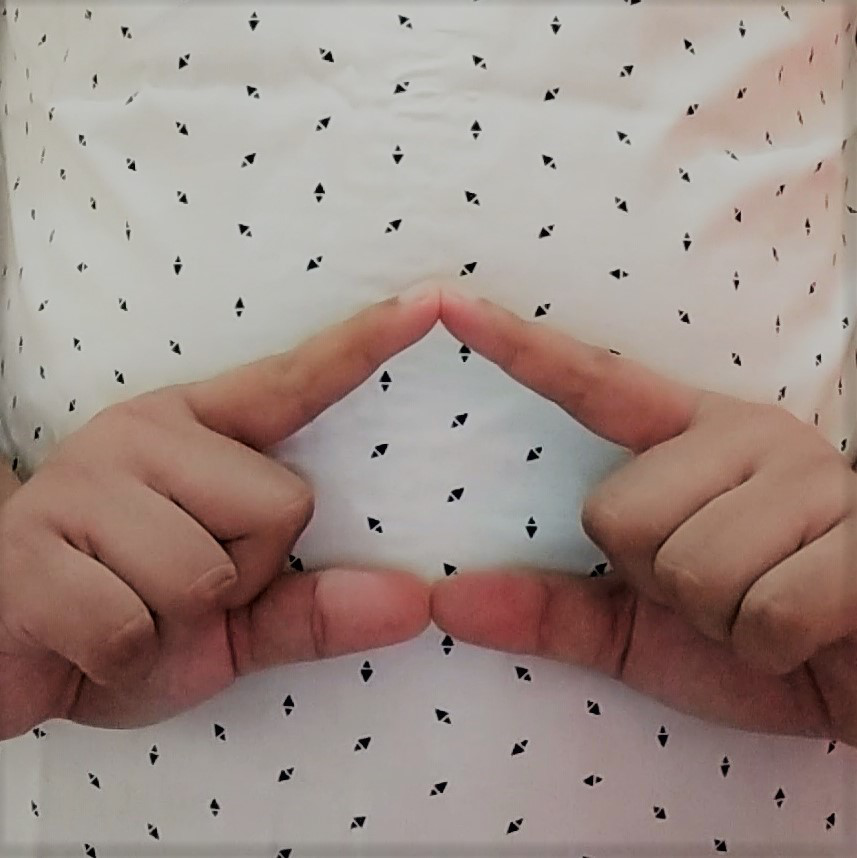

In [4]:
a = list(data_dir.glob('A/*'))
PIL.Image.open(str(a[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 312 files belonging to 26 classes.
Using 250 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 312 files belonging to 26 classes.
Using 62 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


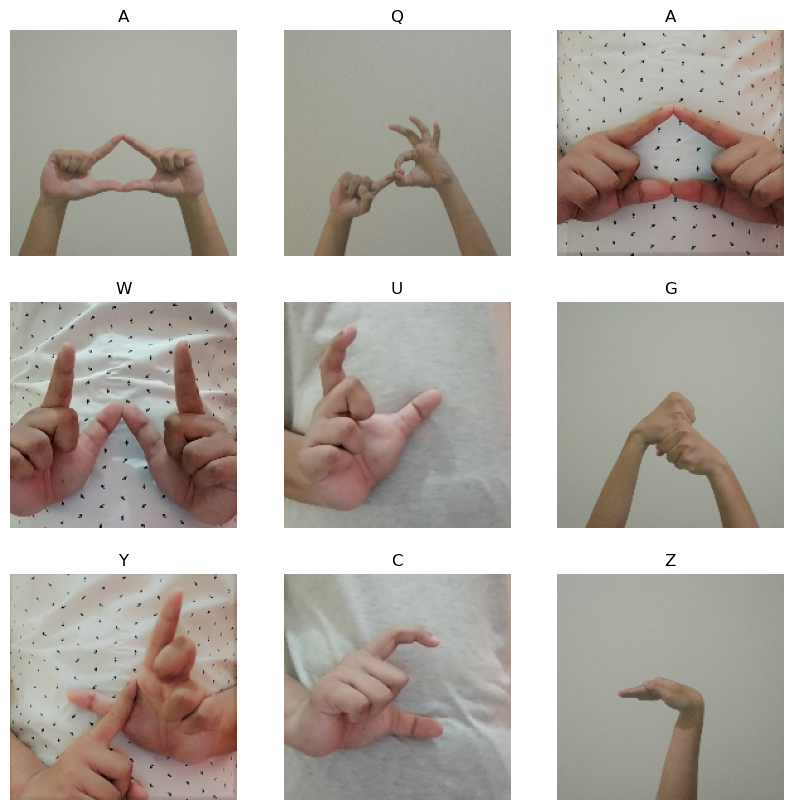

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0012181986 0.86252946


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,991,994 (15.23 MB)

 Trainable params: 3,991,994 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.0273 - loss: 3.6294 - val_accuracy: 0.0323 - val_loss: 3.2881
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.0498 - loss: 3.2563 - val_accuracy: 0.0161 - val_loss: 3.2637
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.0595 - loss: 3.2416 - val_accuracy: 0.0645 - val_loss: 3.2452
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.1611 - loss: 3.1897 - val_accuracy: 0.0323 - val_loss: 3.1699
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.1412 - loss: 3.0883 - val_accuracy: 0.2419 - val_loss: 2.9835
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.3306 - loss: 2.7620 - val_accuracy: 0.3548 - val_loss: 2.5701
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.5852 - loss: 2.1709 - val_accuracy: 0.5161 - val_loss: 1.9036
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.6853 - loss: 1.4659 - val_accuracy: 0.6129 - val_loss:

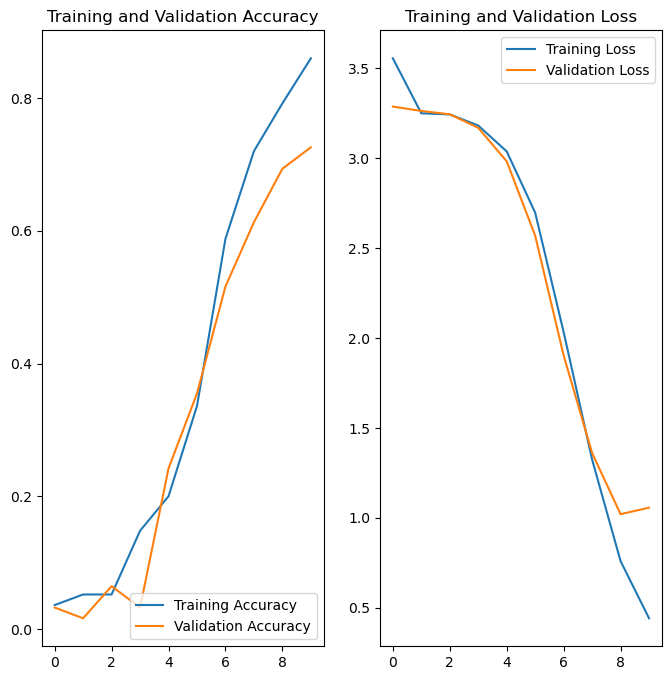

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
sign_path = 'new data/A.jpg'

img = tf.keras.utils.load_img(
    sign_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
This image most likely belongs to K with a 99.17 percent confidence.
